# Segmenting the customer base by service usage patterns


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data Acquisition](#Data_Acquisition)
* [Data Wrangling](#Data_Wrangling)
* [Data Exploration](#Data_Exploration)
* [Model Development](#Model_Development)

## Introduction: Business Problem

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case. 

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns. 

The target field, called __custcat__, has four possible values that correspond to the four customer groups, as follows:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service


### Import the required libraries

In [409]:
import itertools

# scintific computing libraries
import pandas as pd                                            
import numpy as np                                    
import scipy.optimize as opt                            

# visualisation libraries
import matplotlib.pyplot as plt                                       
import seaborn as sns                                   
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter

# algorithmic library
from sklearn import preprocessing
from sklearn import metrics

%matplotlib inline

## Data Acquisition

Load Train Data From CSV File  

In [410]:
train_df = pd.read_csv('teleCust1000t.csv')
print(train_df.shape)
train_df.head()

(1000, 12)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Data Wrangling

In [411]:
train_df.dtypes

region       int64
tenure       int64
age          int64
marital      int64
address      int64
income     float64
ed           int64
employ       int64
retire     float64
gender       int64
reside       int64
custcat      int64
dtype: object

In [412]:
train_df.describe(include='all')

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


Let’s see how many of each class is in our data set 

In [413]:
train_df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers

In [414]:
train_df.isnull().sum()

region     0
tenure     0
age        0
marital    0
address    0
income     0
ed         0
employ     0
retire     0
gender     0
reside     0
custcat    0
dtype: int64

In [415]:
train_df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Data Exploration

In [416]:
train_df.corr()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
region,1.000000,0.016388,0.015034,-0.080637,0.010320,0.023765,-0.057952,0.016335,0.005595,0.050596,-0.065158,-0.023771
tenure,0.016388,1.000000,0.490217,0.154171,0.522952,0.242912,-0.109797,0.520288,0.171143,0.023533,-0.036592,0.166691
age,0.015034,0.490217,1.000000,-0.014433,0.660435,0.327948,-0.154857,0.670047,0.429440,-0.011419,-0.254993,0.056909
marital,-0.080637,0.154171,-0.014433,1.000000,-0.012051,-0.043984,0.001400,-0.002891,-0.078109,0.008345,0.625999,0.083836
address,0.010320,0.522952,0.660435,-0.012051,1.000000,0.226781,-0.128330,0.463291,0.292503,0.008363,-0.201645,0.067913
income,0.023765,0.242912,0.327948,-0.043984,0.226781,1.000000,0.113939,0.516349,-0.083651,0.038706,-0.097591,0.134525
ed,-0.057952,-0.109797,-0.154857,0.001400,-0.128330,0.113939,1.000000,-0.228580,-0.114229,0.006704,0.021045,0.193864
employ,0.016335,0.520288,0.670047,-0.002891,0.463291,0.516349,-0.228580,1.000000,0.277401,0.046016,-0.134683,0.110011
retire,0.005595,0.171143,0.429440,-0.078109,0.292503,-0.083651,-0.114229,0.277401,1.000000,0.053906,-0.140120,0.008908
gender,0.050596,0.023533,-0.011419,0.008345,0.008363,0.038706,0.006704,0.046016,0.053906,1.000000,0.016556,-0.004966


In [417]:
from scipy import stats
columns = train_df.columns
for col in columns:
    pearson_coef, p_value = stats.pearsonr(train_df[col], train_df['custcat'])
    print("The Pearson Correlation Coefficient of  ",col,' is', pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient of   region  is -0.023770651305126858  with a P-value of P = 0.45273695690167415
The Pearson Correlation Coefficient of   tenure  is 0.1666905578826463  with a P-value of P = 1.1469163333143997e-07
The Pearson Correlation Coefficient of   age  is 0.056908927127980645  with a P-value of P = 0.07204630376594753
The Pearson Correlation Coefficient of   marital  is 0.08383570717342463  with a P-value of P = 0.007990459122813438
The Pearson Correlation Coefficient of   address  is 0.06791316309090493  with a P-value of P = 0.031761742075112544
The Pearson Correlation Coefficient of   income  is 0.1345253950226945  with a P-value of P = 1.9709130022836638e-05
The Pearson Correlation Coefficient of   ed  is 0.1938638496145409  with a P-value of P = 6.346268037177314e-10
The Pearson Correlation Coefficient of   employ  is 0.11001069597646493  with a P-value of P = 0.0004919984632841866
The Pearson Correlation Coefficient of   retire  is 0.008907859375651962 

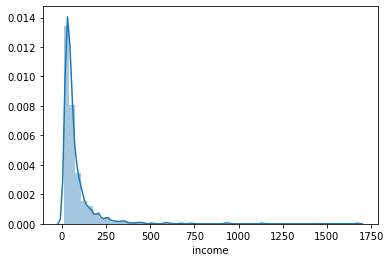

In [418]:
sns.distplot(train_df['income'])

In [419]:
q = train_df['income'].quantile(0.95)
train_df = train_df[train_df['income']<q]
train_df = train_df.reset_index(drop=True)

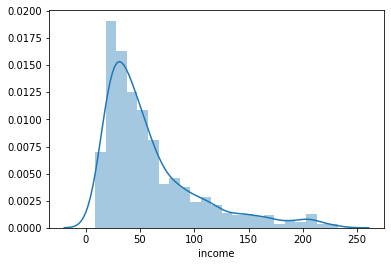

In [420]:
sns.distplot(train_df['income'])

In [421]:
train_df.head()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


### Feature selection

In [422]:
X_train = train_df[['region','tenure','age','marital','address','income','ed','employ','retire','gender','reside']]
print(X_train.shape)
X_train.head()

(950, 11)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside
0,2,13,44,1,9,64.0,4,5,0.0,0,2
1,3,11,33,1,7,136.0,5,5,0.0,0,6
2,3,68,52,1,24,116.0,1,29,0.0,1,2
3,2,33,33,0,12,33.0,2,0,0.0,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4


In [423]:
Y_train = train_df['custcat'].values
Y_train[0:5]

array([1, 4, 3, 1, 3], dtype=int64)

### Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:

In [424]:
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_train[0:5]

array([[-0.01160668, -1.03042482,  0.24362718,  1.00210748, -0.22335106,
         0.0987529 ,  1.09324048, -0.54865469, -0.2281419 , -1.02559049,
        -0.24503989],
       [ 1.21354313, -1.12502773, -0.64499553,  1.00210748, -0.42620336,
         1.7220883 ,  1.9084512 , -0.54865469, -0.2281419 , -1.02559049,
         2.52624459],
       [ 1.21354313,  1.57115512,  0.88989825,  1.00210748,  1.29804121,
         1.2711618 , -1.35239168,  2.04395192, -0.2281419 ,  0.97504804,
        -0.24503989],
       [-0.01160668, -0.08439575, -0.64499553, -0.99789695,  0.08092739,
        -0.60018317, -0.53718096, -1.08878106, -0.2281419 ,  0.97504804,
        -0.93786101],
       [-0.01160668, -0.55741029, -0.88734718,  1.00210748, -0.22335106,
        -0.66782215, -1.35239168, -0.87273051, -0.2281419 , -1.02559049,
         1.14060235]])

### Train Test Split  

In [425]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( X_train, Y_train, test_size=0.2, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (760, 11) (760,)
Test set: (190, 11) (190,)


## Model Development

**K-Nearest Neighbors** is an algorithm for supervised learning. Where the data is 'trained' with data points corresponding to their classification. Once a point is to be predicted, it takes into account the 'K' nearest points to it to determine it's classification.

In [426]:
from sklearn.neighbors import KNeighborsClassifier

In [427]:
KNN = KNeighborsClassifier(n_neighbors = 7)
KNN.fit(x_train, y_train)

y_train_pred = KNN.predict(x_train)
y_test_pred = KNN.predict(x_test)
print("Train set Accuracy: ",metrics.accuracy_score(y_train, y_train_pred))
print("Test set Accuracy: ",metrics.accuracy_score(y_test, y_test_pred))

Train set Accuracy:  0.5184210526315789
Test set Accuracy:  0.39473684210526316


### Accuracy evaluation
In multilabel classification, __accuracy classification score__ is a function that computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

In [428]:
K = 0
acc = 0
for k in range(1,10):
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(x_train, y_train)
    y_test_pred = KNN.predict(x_test)
    acc2 = metrics.accuracy_score(y_test, y_test_pred)
    
    if acc2 > acc:
        K = k
        acc = acc2
        
print( "The best accuracy =", acc, "with k =", K) 

The best accuracy = 0.39473684210526316 with k = 7
